In [1]:
import pandas as pd, seaborn as sns, matplotlib.pyplot as plt
import numpy as np

# Purpose

## Compare sum and bulk EGAD outputs to look for GO terms of interest

In [2]:
sum_EGAD = pd.read_csv('../../data/EAGD/EGAD_sum_pc_OPfiltered.csv')
bulk_EGAD = pd.read_csv('../../data/EAGD/EGAD_bulk_pc_OPfiltered.csv')
expr_bulk = pd.read_csv('../../data/bulk/bulk_pc.csv')
expr_sum = pd.read_csv('../../data/pseudobulk/sum_pseudobulk_pc.csv')

# Plot Sum and Bulk EGAD distribution

In [3]:
# change column names
sum_EGAD.columns = ('sum_auc','sum_avg_node_degree','sum_degree_null_auc')
bulk_EGAD.columns = ('bulk_auc','bulk_avg_node_degree','bulk_degree_null_auc')

In [4]:
#concat dfs
merged =  sum_EGAD.join(bulk_EGAD, how='inner')

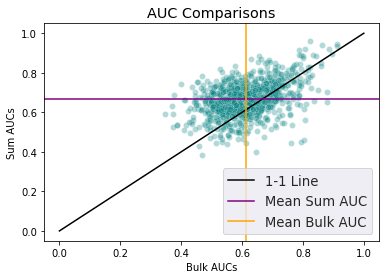

In [5]:
# Create the scatter plot with a new color
sns.scatterplot(data=merged, x='bulk_auc', y='sum_auc', alpha=0.3, color='teal')

# Add the diagonal line with a new color
sns.lineplot(x=[0, 1], y=[0, 1], color='black', linestyle='-', dashes=(5, 5), label='1-1 Line')

# Add lines for mean values with new colors
mean_bulk = merged['bulk_auc'].mean()
mean_sum = merged['sum_auc'].mean()
plt.axhline(mean_sum, color='purple', linestyle='-', label='Mean Sum AUC')
plt.axvline(mean_bulk, color='orange', linestyle='-', label='Mean Bulk AUC')

# Add title and axis labels
sns.set(font_scale=1.2)
plt.title('AUC Comparisons')
plt.xlabel('Bulk AUCs')
plt.ylabel('Sum AUCs')

# Add legend
plt.legend()


# Plot Sum and Bulk EGAD distribution

### But this time, iwant to color with a gradient by how many genes are in each GO term

In [6]:
GO = pd.read_csv('../../data/GO/pro_GO.csv')

In [7]:
def getNumGenesInGO(GO, expr):
    #get measured genes
    genes = expr.columns
    
    # Filter GO-Gene connections for only measured genes
    GO_filtered = GO[np.isin(GO.loc[:,"DB_Object_Symbol"], genes)]    

    # Count the number of genes in each GO term
    counts = GO_filtered.groupby('GO ID')['DB_Object_Symbol'].count()
    
    #return only the GO terms with 20>= genes
    
    return counts[counts>=20]

In [8]:
# Count the number of genes in each GO. Rename the series to "count"
Genes_in_GO = GO.groupby('GO ID')['DB_Object_Symbol'].count().rename('totalCount')

# Join the Genes_in_Go df to our "merged" dataframe which has sum and bulk egad results
merged = merged.join(Genes_in_GO)

In [9]:
# Count the number of genes in our GO terms. This will be the total list so we have to join to our merged df later which contains only the genes we measured in both experiments
countsAbove20Bulk = getNumGenesInGO(GO, expr_bulk)
countsAbove20Sum = getNumGenesInGO(GO, expr_sum)
#Takes ~1m

In [10]:
#Rename series names
countsAbove20Bulk=countsAbove20Bulk.rename('count_bulk')
countsAbove20Sum=countsAbove20Sum.rename('count_sum')

# Join the counts to our merged dataframe
merged=merged.join(countsAbove20Bulk)
merged=merged.join(countsAbove20Sum)

In [11]:
# Get ratio indicating number of sum counts / number of bulk counts
merged['log2RatioSumOverBulk']=np.log2(np.divide(merged.loc[:,'count_sum'], merged.loc[:,'count_bulk']))

In [12]:
# Normalize this ratio to the total coutns in that GO Term
merged['log2RatioSumOverBulkDevTotal']=np.divide(merged.loc[:,'log2RatioSumOverBulk'], merged.loc[:,'totalCount'])

In [13]:
merged.head()
# should have columns indicating the total number of GO terms in 

,sum_auc,sum_avg_node_degree,sum_degree_null_auc,bulk_auc,bulk_avg_node_degree,bulk_degree_null_auc,totalCount,count_bulk,count_sum,log2RatioSumOverBulk,log2RatioSumOverBulkDevTotal
GO:0002250,0.843344,5194.463508,0.212810,0.789341,462.346222,0.243478,442,182,304,0.740133,0.001675
GO:0045087,0.691922,7209.645480,0.407198,0.674342,796.391609,0.379402,539,293,513,0.808058,0.001499
GO:0006955,0.755970,6222.323850,0.289623,0.763922,493.470409,0.254211,558,284,492,0.792767,0.001421
GO:0050830,0.734289,5483.971948,0.266064,0.730477,444.504651,0.291142,174,93,166,0.835881,0.004804
GO:0007015,0.526417,7876.407623,0.451428,0.596887,1027.879184,0.474924,114,52,113,1.119739,0.009822


In [14]:
import matplotlib.pyplot as plt
import numpy as np
import seaborn as sns
from matplotlib.colors import ListedColormap

# Define custom colormap for ordinal data
n = 10
palette = sns.color_palette("husl", n)
cmap = ListedColormap(palette)

# Create the scatter plot with a red color gradient
plt.figure(figsize=(15, 15))
scatter_plot = sns.scatterplot(data=merged, x='bulk_auc', y='sum_auc', alpha=1, hue='log2RatioSumOverBulkDevTotal', palette=cmap)

# Add the diagonal line with a new color
line_plot = sns.lineplot(x=[0, 1], y=[0, 1], color='black', linestyle='-', dashes=(5, 5), label='1-1 Line')

# Add lines for mean values with new colors
# mean_bulk = merged['bulk_auc'].mean()
# mean_sum = merged['sum_auc'].mean()
# plt.axhline(mean_sum, color='purple', linestyle='-', label='Mean Sum AUC')
# plt.axvline(mean_bulk, color='orange', linestyle='-', label='Mean Bulk AUC')

# Add title and axis labels
sns.set(font_scale=1.2)
plt.title('AUC Comparisons')
plt.xlabel('Bulk AUCs')
plt.ylabel('Sum AUCs')

# Move the legend to the right side of the graph
plt.legend(bbox_to_anchor=(1.05, 1), loc='upper left')

# Show the plot
plt.show()


NameError: name 'matplotlib' is not defined

# Identify GO's of interest



In [ ]:

# get the two highest values from column bulk_auc
highest_bulk = merged.nlargest(500, 'bulk_auc')

# get the middle value from column B
middle_sc = merged.nsmallest(1000, 'bulk_auc').nlargest(500, 'sum_auc')

# print the results
print('Highest values in column A:')
print(highest_bulk)

print('Middle value in column B:')
print(middle_sc)



Highest values in column A:
             sum_auc  sum_avg_node_degree  sum_degree_null_auc  bulk_auc  \
GO:0042776  0.935349         10605.405194             0.929248  0.912429   
GO:0006120  0.948081         10637.540654             0.921659  0.912148   
GO:0031424  0.895229          4231.658564             0.141695  0.895973   
GO:0006956  0.921372          5564.959468             0.220891  0.885661   
GO:0031640  0.653319          4006.699228             0.196785  0.878598   
...              ...                  ...                  ...       ...   
GO:0006633  0.643540          8577.335467             0.541091  0.591766   
GO:0051028  0.693712          9803.343315             0.732382  0.591587   
GO:0050673  0.649042          7412.955797             0.421267  0.591313   
GO:0031100  0.499426          7075.552554             0.379832  0.591294   
GO:0016575  0.685262          9721.736248             0.721159  0.591253   

            bulk_avg_node_degree  bulk_degree_null_auc  cou

In [ ]:
def filter_dataframe_by_bounds(df, column_name, lower_bound, upper_bound):
    """
    Filter a pandas dataframe by a column within a given range.

    Args:
        df (pandas.DataFrame): The pandas dataframe to filter.
        column_name (str): The name of the column to filter on.
        lower_bound (float): The lower bound of the range.
        upper_bound (float): The upper bound of the range.

    Returns:
        pandas.DataFrame: The filtered dataframe.
    """
    return df[(df[column_name] > lower_bound) & (df[column_name] < upper_bound)]


In [ ]:
interest_HB = filter_dataframe_by_bounds(filter_dataframe_by_bounds(merged, 'bulk_auc', lower_bound=0.6, upper_bound=0.7), 'sum_auc', lower_bound=0.85, upper_bound=0.90)

## GO:0031640

The highest bulk point.


# Graphing Expression of Genes in GO:0015889

Get Genes in GO:0031640

In [ ]:
GO1 = GO[GO.loc[:,'GO ID'] == 'GO:0031640']

In [ ]:
len(GO1.iloc[:,0].unique()) # There are 38 genes that we have data for in this GO term

38

Retreive Expression of those genes

In [ ]:
# load expression data 
expr_bulk = pd.read_csv('../../data/bulk/bulk_pc.csv')
expr_sum = pd.read_csv('../../data/pseudobulk/sum_pseudobulk_pc.csv')

In [ ]:
expr_bulk.head()

,Unnamed: 0,SAMD11,NOC2L,KLHL17,PLEKHN1,PERM1,HES4,ISG15,AGRN,RNF223,...,CD248,RIN1,BRMS1,B4GAT1,SLC29A2,NPAS4,MRPL11,PELI3,DPP3,BBS1
0,Adipose Tissue,2.488541,52.590730,10.202082,0.764161,0.542800,28.092880,49.740883,22.721622,0.073909,...,373.130430,8.924957,42.621600,29.333443,16.796164,0.462180,22.507181,10.040108,15.335722,10.832185
1,Muscle,0.525075,63.626060,2.533191,0.599506,134.565610,6.264792,8.250571,2.752260,0.082165,...,12.820538,6.090418,27.346762,22.068040,96.723015,0.064491,20.161041,11.936096,16.344252,3.712623
2,Blood Vessel,9.365273,60.303173,13.137567,0.965409,1.198790,89.542460,69.756584,25.317816,0.060386,...,65.065470,6.044426,40.027714,32.928562,5.016324,2.329165,27.960186,20.370910,16.448154,16.562885
3,Heart,4.393053,27.355950,4.148498,0.300845,48.338528,29.893776,21.709148,9.072904,0.088303,...,23.492180,2.566503,16.040676,33.663765,19.230131,0.188245,14.523070,4.841727,6.171713,4.831588
4,Uterus,15.662474,79.359980,19.312246,0.856613,1.142908,44.244778,43.023876,30.398806,0.101918,...,118.888620,11.958544,46.913030,69.397180,5.470922,9.988495,32.256485,26.929302,16.724983,27.259022


In [ ]:
# Get Expression data for the GO term in bulk and sum data
expr_GO1_bulk = expr_bulk.loc[:,expr_bulk.columns.isin(GO1.loc[:,'DB_Object_Symbol'])] # has 3 genes
expr_GO1_sum = expr_sum.loc[:,expr_sum.columns.isin(GO1.loc[:,'DB_Object_Symbol'])] # has 9 genes

bulk_GO_annot = pd.DataFrame({'gene':expr_GO1_bulk.columns,
                               'meta':'GO'})
sum_GO_annot = pd.DataFrame({'gene':expr_GO1_sum.columns,
                               'meta':'GO'})

# # Add a metadata column saying these are GO affiliated genes
# expr_GO1_bulk = expr_GO1_bulk.assign(meta="GO")
# expr_GO1_sum = expr_GO1_sum.assign(meta="GO")

# # Melt dataframes by meta column
# melt_GO1_bulk = pd.melt(expr_GO1_bulk, id_vars=['meta'], var_name='variable', value_name='value')
# melt_GO1_sum = pd.melt(expr_GO1_sum, id_vars=['meta'], var_name='variable', value_name='value')


In [ ]:
# Sample 50 random expression profiles
expr_bulk_rand = expr_bulk.sample(n=1, axis=1)
expr_sum_rand = expr_sum.sample(n=1, axis = 1)

#build annot table 
bulk_rand_annot = pd.DataFrame({'gene':expr_bulk_rand.columns,
                               'meta':'rand'})
sum_rand_annot = pd.DataFrame({'gene':expr_sum_rand.columns,
                               'meta':'rand'})

# # Add a metadata column saying these are random affiliated genes
# expr_GO1_bulk = expr_GO1_bulk.assign(meta="rand")
# expr_GO1_sum = expr_GO1_sum.assign(meta="rand")


# # Melt dataframes by meta column
# melt_GO1_bulk = pd.melt(expr_GO1_bulk, id_vars=['meta'], var_name='variable', value_name='value')
# melt_GO1_sum = pd.melt(expr_GO1_sum, id_vars=['meta'], var_name='variable', value_name='value')



In [ ]:
# concat dataframes
plot_GO1_bulk = pd.concat([expr_GO1_bulk, expr_bulk_rand], axis = 1)
plot_GO1_sum = pd.concat([expr_GO1_sum,expr_sum_rand], axis = 1)

# Concat annotation dfs
annot_df_bulk = pd.concat([bulk_GO_annot,bulk_rand_annot], axis = 0)
annot_df_bulk.index = annot_df_bulk.iloc[:,0]
annot_df_bulk = annot_df_bulk.iloc[:,1]

annot_df_sum = pd.concat([sum_GO_annot,sum_rand_annot], axis = 0)
annot_df_sum.index = annot_df_sum.iloc[:,0]
annot_df_sum = annot_df_sum.iloc[:,1]



In [ ]:
# Prepare Categorical variable
my_palette = {'rand': 'blue',
              'GO': 'red'}

# row colors is a series where index is gene, and value is the color that that gene needs to be 
row_colors_bulk= annot_df_bulk.map(my_palette)
row_colors_sum= annot_df_sum.map(my_palette)

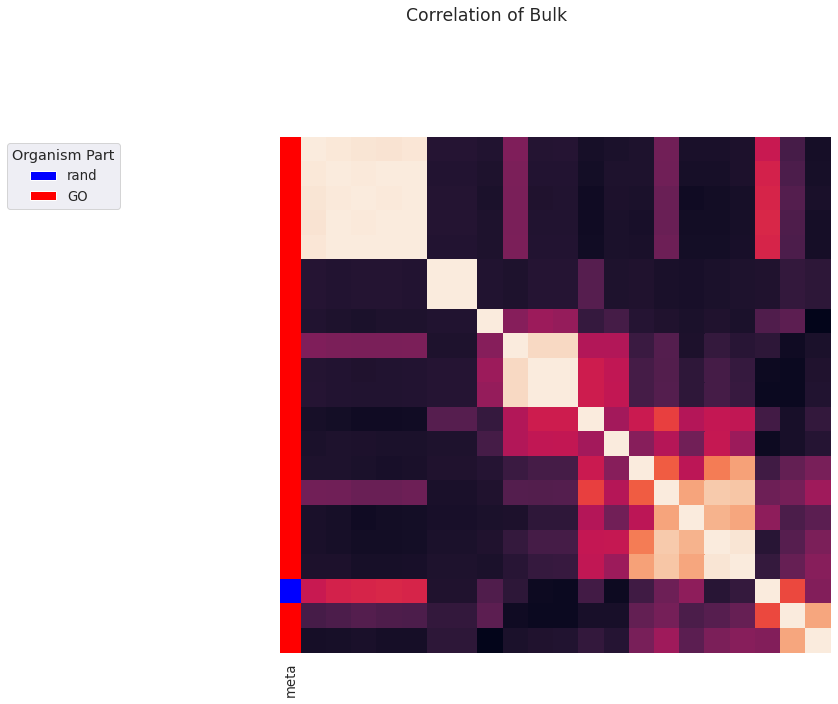

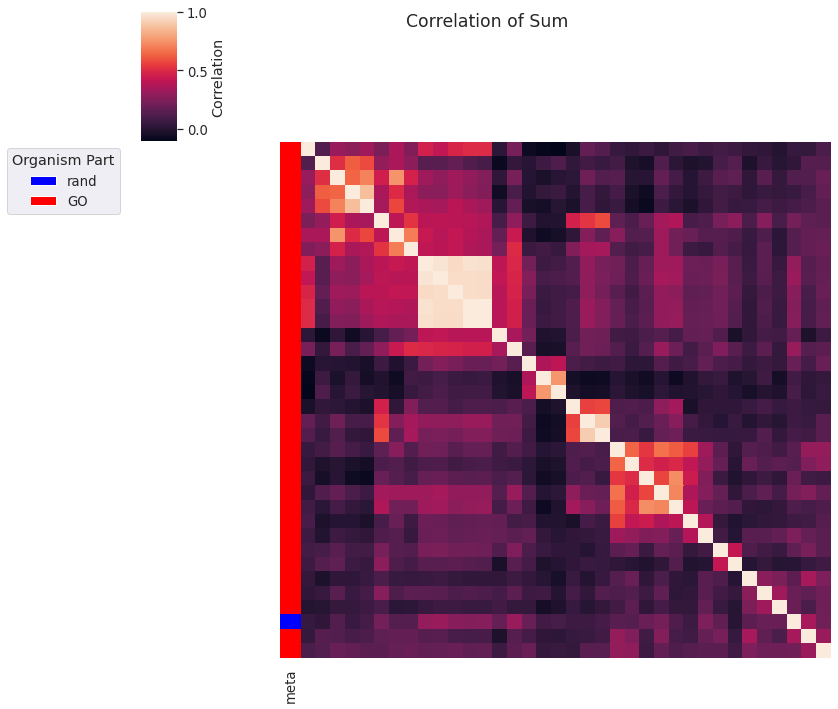

In [ ]:
from matplotlib.patches import Patch

# Create the first cluster map
fig1 = sns.clustermap(plot_GO1_bulk.corr(), row_colors=row_colors_bulk, cbar_pos=None, xticklabels=False,
                      yticklabels=False, dendrogram_ratio=0.2)
# Set the title of the first plot
fig1.fig.suptitle("Correlation of Bulk")

# Remove the dendrograms from the first plot
fig1.ax_row_dendrogram.set_visible(False)
fig1.ax_col_dendrogram.set_visible(False)

# Add a legend
handles = [Patch(facecolor=my_palette[key]) for key in my_palette]
plt.legend(handles, my_palette, title='Organism Part',
           bbox_to_anchor=(0, 0.8), bbox_transform=plt.gcf().transFigure, loc='upper right')

# Create the second cluster map
fig2 = sns.clustermap(plot_GO1_sum.corr(), row_colors=row_colors_sum, cbar_kws={'label': 'Correlation'}, 
                      xticklabels=False, yticklabels=False, dendrogram_ratio=0.2)
# Set the title of the second plot
fig2.fig.suptitle("Correlation of Sum")

# Remove the dendrograms from the second plot
fig2.ax_row_dendrogram.set_visible(False)
fig2.ax_col_dendrogram.set_visible(False)

# Add a legend
handles = [Patch(facecolor=my_palette[key]) for key in my_palette]
plt.legend(handles, my_palette, title='Organism Part',
           bbox_to_anchor=(0, 0.8), bbox_transform=plt.gcf().transFigure, loc='upper right')

# Display the figure
plt.show()

GO:0000387



In [ ]:
def GOvsRand(GOstr, GO, expr_bulk, expr_sum):
    GO1 = GO[GO.loc[:,'GO ID'] == GOstr]
    
    # Get Expression data for the GO term in bulk and sum data
    expr_GO1_bulk = expr_bulk.loc[:,expr_bulk.columns.isin(GO1.loc[:,'DB_Object_Symbol'])] # has 3 genes
    expr_GO1_sum = expr_sum.loc[:,expr_sum.columns.isin(GO1.loc[:,'DB_Object_Symbol'])] # has 9 genes

    bulk_GO_annot = pd.DataFrame({'gene':expr_GO1_bulk.columns,
                                'meta':'GO'})
    sum_GO_annot = pd.DataFrame({'gene':expr_GO1_sum.columns,
                                'meta':'GO'})
    
    
    # Sample 50 random expression profiles
    expr_bulk_rand = expr_bulk.sample(n=1, axis=1)
    expr_sum_rand = expr_sum.sample(n=1, axis = 1)

    #build annot table 
    bulk_rand_annot = pd.DataFrame({'gene':expr_bulk_rand.columns,
                                'meta':'rand'})
    sum_rand_annot = pd.DataFrame({'gene':expr_sum_rand.columns,
                                'meta':'rand'})


    # concat dataframes
    plot_GO1_bulk = pd.concat([expr_GO1_bulk, expr_bulk_rand], axis = 1)
    plot_GO1_sum = pd.concat([expr_GO1_sum,expr_sum_rand], axis = 1)

    # Concat annotation dfs
    annot_df_bulk = pd.concat([bulk_GO_annot,bulk_rand_annot], axis = 0)
    annot_df_bulk.index = annot_df_bulk.iloc[:,0]
    annot_df_bulk = annot_df_bulk.iloc[:,1]

    annot_df_sum = pd.concat([sum_GO_annot,sum_rand_annot], axis = 0)
    annot_df_sum.index = annot_df_sum.iloc[:,0]
    annot_df_sum = annot_df_sum.iloc[:,1]


    # Prepare Categorical variable
    my_palette = {'rand': 'blue',
                'GO': 'red'}

    # row colors is a series where index is gene, and value is the color that that gene needs to be 
    row_colors_bulk= annot_df_bulk.map(my_palette)
    row_colors_sum= annot_df_sum.map(my_palette)


    # Create the first cluster map
    fig1 = sns.clustermap(plot_GO1_bulk.corr(), row_colors=row_colors_bulk, cbar_pos=None, xticklabels=False,
                        yticklabels=False, dendrogram_ratio=0.2)
    # Set the title of the first plot
    fig1.fig.suptitle("Correlation of Bulk")

    # Remove the dendrograms from the first plot
    fig1.ax_row_dendrogram.set_visible(False)
    fig1.ax_col_dendrogram.set_visible(False)

    # Add a legend
    handles = [Patch(facecolor=my_palette[key]) for key in my_palette]
    plt.legend(handles, my_palette, title='Organism Part',
            bbox_to_anchor=(0, 0.8), bbox_transform=plt.gcf().transFigure, loc='upper right')

    # Create the second cluster map
    fig2 = sns.clustermap(plot_GO1_sum.corr(), row_colors=row_colors_sum, cbar_kws={'label': 'Correlation'}, 
                        xticklabels=False, yticklabels=False, dendrogram_ratio=0.2)
    # Set the title of the second plot
    fig2.fig.suptitle("Correlation of Sum")

    # Remove the dendrograms from the second plot
    fig2.ax_row_dendrogram.set_visible(False)
    fig2.ax_col_dendrogram.set_visible(False)

    # Add a legend
    handles = [Patch(facecolor=my_palette[key]) for key in my_palette]
    plt.legend(handles, my_palette, title='Organism Part',
            bbox_to_anchor=(0, 0.8), bbox_transform=plt.gcf().transFigure, loc='upper right')

    # Display the figure
    plt.show()

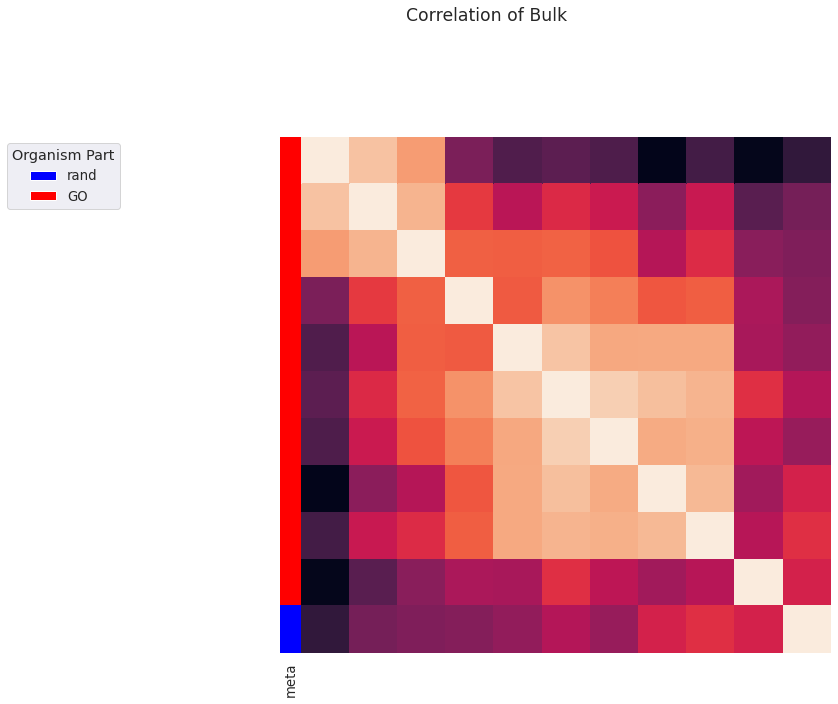

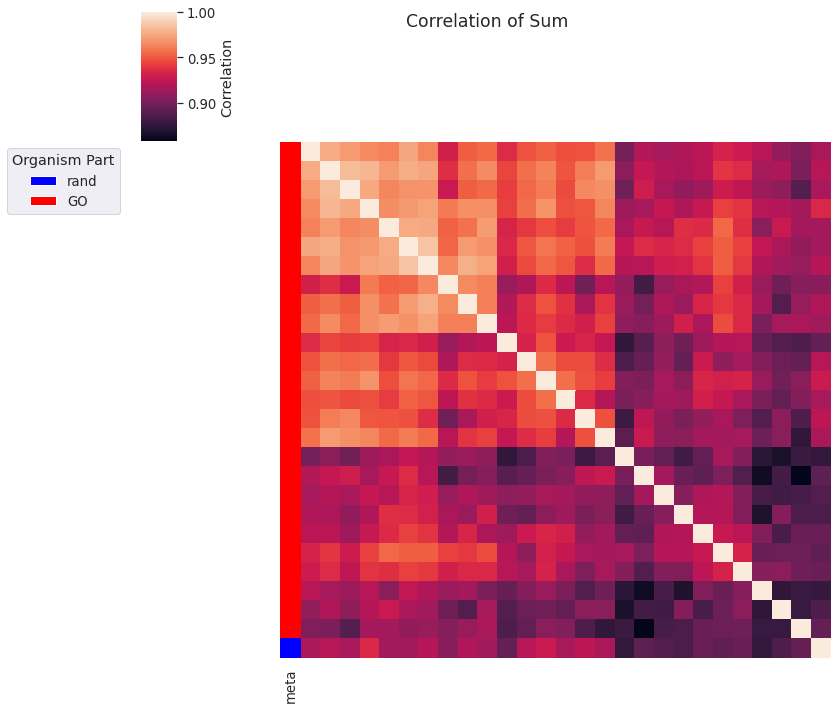

In [ ]:
GOvsRand(GOstr="GO:0000387", GO=GO, expr_bulk=expr_bulk, expr_sum=expr_sum)